#Obejective
This project focuses on implementing object detection techniques to locate and identify cars in images. The goal is to explore two different approaches:

1. custom-built CNN model for bounding box regression.

2. pre-trained YOLOv11 model for fine-tuning and inference.

It covers:

Data loading and preprocessing

Model training and evaluation

Visualizing detection results

Hyperparameter tuning and model comparison



#Import Dependencies


In [1]:
import os, time, random
import numpy as np
import pandas as pd
import cv2, torch
from tqdm.auto import tqdm
import shutil as sh

from IPython.display import Image, clear_output
import matplotlib.pyplot as plt
%matplotlib inline

#Data Preparation

In [2]:
from google.colab import files
uploaded = files.upload()

Saving archive (1).zip to archive (1).zip


In [3]:
import os

for fname in uploaded.keys():
    print(f"Uploaded file: {fname}")


Uploaded file: archive (1).zip


In [4]:
import zipfile

# Replace 'your_file.zip' with your actual filename
zip_path = "/content/archive (1).zip"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("car_dataset")  # Extracts to folder named 'car_dataset'


In [5]:
import os

for root, dirs, files in os.walk("car_dataset"):
    print(root, len(files), "files")


car_dataset 0 files
car_dataset/data 2 files
car_dataset/data/testing_images 175 files
car_dataset/data/training_images 1001 files


In [6]:
import os

for root, dirs, files in os.walk("car_dataset"):
    for file in files:
        print(os.path.join(root, file))


car_dataset/data/train_solution_bounding_boxes (1).csv
car_dataset/data/sample_submission.csv
car_dataset/data/testing_images/vid_5_29620.jpg
car_dataset/data/testing_images/vid_5_27720.jpg
car_dataset/data/testing_images/vid_5_31200.jpg
car_dataset/data/testing_images/vid_5_29400.jpg
car_dataset/data/testing_images/vid_5_26660.jpg
car_dataset/data/testing_images/vid_5_31280.jpg
car_dataset/data/testing_images/vid_5_25220.jpg
car_dataset/data/testing_images/vid_5_27640.jpg
car_dataset/data/testing_images/vid_5_28640.jpg
car_dataset/data/testing_images/vid_5_31300.jpg
car_dataset/data/testing_images/vid_5_30940.jpg
car_dataset/data/testing_images/vid_5_30660.jpg
car_dataset/data/testing_images/vid_5_31700.jpg
car_dataset/data/testing_images/vid_5_29580.jpg
car_dataset/data/testing_images/vid_5_28660.jpg
car_dataset/data/testing_images/vid_5_29060.jpg
car_dataset/data/testing_images/vid_5_26800.jpg
car_dataset/data/testing_images/vid_5_31360.jpg
car_dataset/data/testing_images/vid_5_2954

In [7]:
import pandas as pd

train_df = pd.read_csv('/content/car_dataset/data/train_solution_bounding_boxes (1).csv')


train_df.head()


,image,xmin,ymin,xmax,ymax
0,vid_4_1000.jpg,281.259045,187.035071,327.727931,223.225547
1,vid_4_10000.jpg,15.163531,187.035071,120.329957,236.430180
2,vid_4_10040.jpg,239.192475,176.764801,361.968162,236.430180
3,vid_4_10020.jpg,496.483358,172.363256,630.020260,231.539575
4,vid_4_10060.jpg,16.630970,186.546010,132.558611,238.386422


In [8]:
image_path = '/content/car_dataset/data/training_images/vid_4_10200.jpg'

In [9]:
import os
import cv2
import matplotlib.pyplot as plt

def show_sample(image_id):
    img_path = os.path.join(image_path, image_id)
    print(f"Trying to load: {img_path}")  # Debug print

    if not os.path.exists(img_path):
        print(f"❌ Image not found: {img_path}")
        return

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    boxes = train_df[train_df['image'] == image_id]
    for _, row in boxes.iterrows():
        x1, y1, x2, y2 = int(row['xmin']), int(row['ymin']), int(row['xmax']), int(row['ymax'])
        cv2.rectangle(image, (x1, y1), (x2, y2), (0,255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(image)
    plt.axis('off')
    plt.title(image_id)
    plt.show()


Trying to load: /content/car_dataset/data/training_images/vid_4_1000.jpg


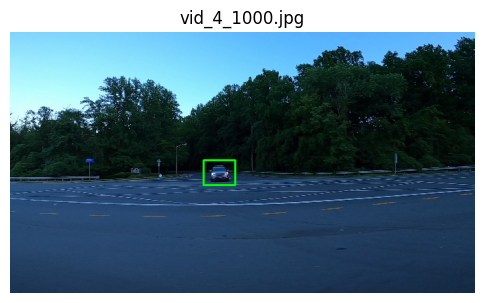

Trying to load: /content/car_dataset/data/training_images/vid_4_10480.jpg


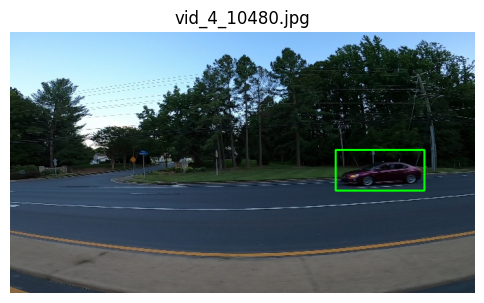

Trying to load: /content/car_dataset/data/training_images/vid_4_12060.jpg


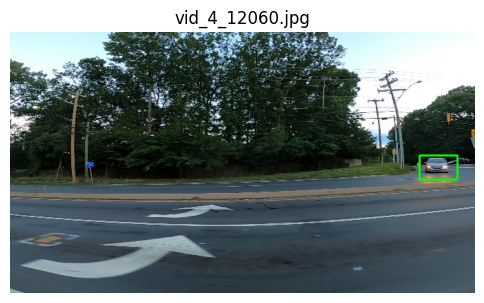

In [10]:
# Ensure image_path is set
image_path = "/content/car_dataset/data/training_images"

# Try showing the first sample
show_sample(train_df['image'].iloc[0])
show_sample(train_df['image'].iloc[10])
show_sample(train_df['image'].iloc[34])

Train Val Test Split

In [11]:
for split in ['train', 'val', 'test']:
    os.makedirs(f'yolo_dataset/images/{split}', exist_ok=True)
    os.makedirs(f'yolo_dataset/labels/{split}', exist_ok=True)

In [12]:
df = pd.read_csv("/content/car_dataset/data/train_solution_bounding_boxes (1).csv")
df['image'] = df['image'].str.strip()

In [13]:
from sklearn.model_selection import train_test_split

image_names = df['image'].unique()
train_imgs, valtest_imgs = train_test_split(image_names, test_size=0.3, random_state=42)
val_imgs, test_imgs = train_test_split(valtest_imgs, test_size=0.5, random_state=42)

split_map = {img: 'train' for img in train_imgs}
split_map.update({img: 'val' for img in val_imgs})
split_map.update({img: 'test' for img in test_imgs})


In [14]:
import shutil
for img_name in image_names:
    split = split_map[img_name]
    img_path = f'car_dataset/data/training_images/{img_name}'
    img = cv2.imread(img_path)
    if img is None: continue
    h, w = img.shape[:2]
    yolo_labels = []
    for _, row in df[df['image'] == img_name].iterrows():
        x_center = ((row['xmin'] + row['xmax']) / 2) / w
        y_center = ((row['ymin'] + row['ymax']) / 2) / h
        bw = (row['xmax'] - row['xmin']) / w
        bh = (row['ymax'] - row['ymin']) / h
        yolo_labels.append(f"0 {x_center:.6f} {y_center:.6f} {bw:.6f} {bh:.6f}")
    with open(f"yolo_dataset/labels/{split}/{img_name.replace('.jpg', '.txt')}", 'w') as f:
        f.write("\n".join(yolo_labels))
    shutil.copy(img_path, f"yolo_dataset/images/{split}/{img_name}")

In [15]:
with open("yolo_dataset/data.yaml", "w") as f:
    f.write("""path: yolo_dataset
train: images/train
val: images/val
test: images/test
nc: 1
names: ['car']
""")

In [16]:
def show_sample(image_path, label_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w = img.shape[:2]
    with open(label_path, 'r') as f:
        for line in f:
            _, x, y, bw, bh = map(float, line.strip().split())
            x1 = int((x - bw / 2) * w)
            y1 = int((y - bh / 2) * h)
            x2 = int((x + bw / 2) * w)
            y2 = int((y + bh / 2) * h)
            cv2.rectangle(img, (x1, y1), (x2, y2), (0,255, 0), 2)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

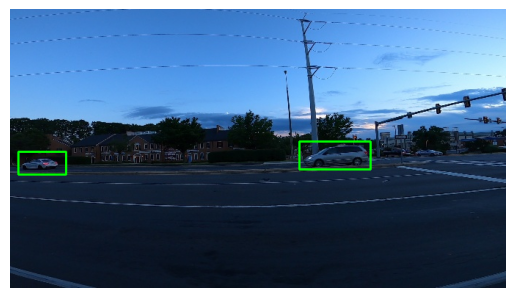

In [17]:
sample_img = os.listdir('yolo_dataset/images/train')[0]
show_sample(f'yolo_dataset/images/train/{sample_img}', f'yolo_dataset/labels/train/{sample_img.replace(".jpg", ".txt")}')

#Modeling

In [18]:
!pip install -q ultralytics
from ultralytics import YOLO

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 84.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 88.2 MB/s eta 0:00:00
Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralyti

#Training

In [19]:
model = YOLO('yolo11n.yaml')
results = model.train(data='yolo_dataset/data.yaml', epochs=20, imgsz=512, augment=True)


Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, pr

100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]

Overriding model.yaml nc=80 with nc=1

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295424  ultralytics

 20                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
 21            [-1, 10]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 22                  -1  1    378880  ultralytics.nn.modules.block.C3k2            [384, 256, 1, True]           
 23        [16, 19, 22]  1    430867  ultralytics.nn.modules.head.Detect           [1, [64, 128, 256]]           
YOLO11n summary: 181 layers, 2,590,035 parameters, 2,590,019 gradients, 6.4 GFLOPs

Freezing layer 'model.23.dfl.conv.weight'
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 28.5±9.0 MB/s, size: 98.6 KB)


train: Scanning /content/yolo_dataset/labels/train... 248 images, 0 backgrounds, 0 corrupt: 100%|██████████| 248/248 [00:00<00:00, 339.99it/s]

train: New cache created: /content/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 25.0±12.0 MB/s, size: 91.2 KB)


val: Scanning /content/yolo_dataset/labels/val... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<00:00, 370.05it/s]

val: New cache created: /content/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20         0G      5.406      5.416      4.195         13        512: 100%|██████████| 16/16 [02:18<00:00,  8.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:07<00:00,  3.57s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20         0G      4.721      4.852      3.716         32        512: 100%|██████████| 16/16 [02:12<00:00,  8.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.20s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20         0G      3.383      3.331      2.987         32        512: 100%|██████████| 16/16 [02:16<00:00,  8.55s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.18s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20         0G      2.926      2.738      2.572         25        512: 100%|██████████| 16/16 [02:09<00:00,  8.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.09s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20         0G       2.84      2.501      2.449         22        512: 100%|██████████| 16/16 [02:12<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.82s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20         0G      2.669      2.316      2.375         12        512: 100%|██████████| 16/16 [02:11<00:00,  8.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.86s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20         0G      2.557      2.056      2.254         31        512: 100%|██████████| 16/16 [02:16<00:00,  8.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]

                   all         53         95          0          0          0          0



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20         0G      2.394      1.967       2.16         21        512: 100%|██████████| 16/16 [02:12<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.27s/it]

                   all         53         95   0.000531     0.0421   0.000288   0.000107



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20         0G      2.211      1.697       2.04         23        512: 100%|██████████| 16/16 [02:18<00:00,  8.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.22s/it]

                   all         53         95    0.00547      0.463     0.0629     0.0193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20         0G      2.129      1.594       1.97         16        512: 100%|██████████| 16/16 [02:12<00:00,  8.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.29s/it]

                   all         53         95      0.451      0.294      0.308      0.117


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20         0G      2.059      1.822      1.984         13        512: 100%|██████████| 16/16 [02:15<00:00,  8.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.30s/it]

                   all         53         95      0.497      0.531      0.473      0.174



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20         0G      1.996      1.706      1.929         10        512: 100%|██████████| 16/16 [02:12<00:00,  8.30s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.15s/it]

                   all         53         95      0.655      0.589      0.663      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20         0G      1.938      1.589      1.881         10        512: 100%|██████████| 16/16 [02:11<00:00,  8.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.79s/it]

                   all         53         95       0.89      0.684      0.824      0.376



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20         0G      1.835       1.44      1.782         13        512: 100%|██████████| 16/16 [02:09<00:00,  8.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.95s/it]

                   all         53         95      0.834      0.747      0.838      0.465



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20         0G      1.909      1.436      1.839         10        512: 100%|██████████| 16/16 [02:09<00:00,  8.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.21s/it]

                   all         53         95      0.795      0.777      0.852      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20         0G      1.763      1.366      1.743         10        512: 100%|██████████| 16/16 [02:10<00:00,  8.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.84s/it]

                   all         53         95      0.843        0.8       0.87      0.496



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20         0G      1.811      1.363      1.744          9        512: 100%|██████████| 16/16 [02:16<00:00,  8.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.80s/it]

                   all         53         95      0.853      0.768      0.868       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20         0G      1.783      1.316      1.698         12        512: 100%|██████████| 16/16 [02:11<00:00,  8.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:05<00:00,  2.82s/it]

                   all         53         95       0.87      0.776      0.863      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20         0G      1.721      1.278      1.685          8        512: 100%|██████████| 16/16 [02:10<00:00,  8.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.02s/it]

                   all         53         95      0.914      0.781      0.887      0.468



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20         0G      1.748      1.295      1.717         11        512: 100%|██████████| 16/16 [02:10<00:00,  8.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:06<00:00,  3.23s/it]

                   all         53         95      0.913        0.8      0.897      0.478



20 epochs completed in 0.775 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train/weights/best.pt, 5.4MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:12<00:00,  6.44s/it]


                   all         53         95      0.845      0.726      0.845      0.485
Speed: 0.9ms preprocess, 230.8ms inference, 0.0ms loss, 1.3ms postprocess per image
Results saved to runs/detect/train


#Evaluation

In [ ]:
metrics = model.val()
model.predict('yolo_dataset/images/test', save=True, conf=0.25)

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 998.4±499.7 MB/s, size: 109.6 KB)


val: Scanning /content/yolo_dataset/labels/val.cache... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:23<00:00,  5.99s/it]

#Tuning

In [ ]:
model.train(data='yolo_dataset/data.yaml', epochs=40, lr0=0.005, batch=8, imgsz=512)

Ultralytics 8.3.156 🚀 Python-3.11.13 torch-2.6.0+cu124 CPU (Intel Xeon 2.20GHz)
engine/trainer: agnostic_nms=False, amp=True, augment=True, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=512, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.005, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.yaml, momentum=0.937, mosaic=1.0, multi_scale=False, name=train4, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, p

train: Scanning /content/yolo_dataset/labels/train.cache... 248 images, 0 backgrounds, 0 corrupt: 100%|██████████| 248/248 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, method='weighted_average', num_output_channels=3), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1095.6±419.8 MB/s, size: 91.2 KB)



val: Scanning /content/yolo_dataset/labels/val.cache... 53 images, 0 backgrounds, 0 corrupt: 100%|██████████| 53/53 [00:00<?, ?it/s]

Plotting labels to runs/detect/train4/labels.jpg... 


optimizer: 'optimizer=auto' found, ignoring 'lr0=0.005' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 512 train, 512 val
Using 0 dataloader workers
Logging results to runs/detect/train4
Starting training for 40 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/40         0G      2.017      1.417      1.783         11        512: 100%|██████████| 31/31 [02:10<00:00,  4.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

                   all         53         95      0.682      0.362      0.463      0.179



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/40         0G      1.918      1.312       1.75         19        512: 100%|██████████| 31/31 [02:08<00:00,  4.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.46s/it]

                   all         53         95      0.852      0.779      0.872       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/40         0G      1.911      1.268      1.721         29        512: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.64s/it]

                   all         53         95       0.76      0.669      0.703      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/40         0G      1.825      1.278      1.707         25        512: 100%|██████████| 31/31 [02:06<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.63s/it]

                   all         53         95      0.878      0.758      0.863      0.478



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/40         0G      1.827      1.147      1.686         24        512: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.42s/it]

                   all         53         95      0.839      0.789      0.865      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/40         0G      1.773      1.154      1.644         10        512: 100%|██████████| 31/31 [02:06<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

                   all         53         95      0.903      0.684      0.822       0.41



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/40         0G       1.81      1.138      1.607         26        512: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.53s/it]

                   all         53         95      0.883      0.793      0.879      0.459



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/40         0G       1.84      1.161      1.632         39        512: 100%|██████████| 31/31 [02:06<00:00,  4.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.43s/it]

                   all         53         95      0.974      0.785      0.907      0.543



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/40         0G      1.693      1.061      1.535         22        512: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

                   all         53         95       0.89      0.848      0.902      0.504



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/40         0G      1.702      1.045      1.575         16        512: 100%|██████████| 31/31 [02:06<00:00,  4.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.48s/it]

                   all         53         95      0.896      0.874      0.929      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/40         0G      1.716      1.013      1.532         18        512: 100%|██████████| 31/31 [02:08<00:00,  4.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.44s/it]

                   all         53         95      0.912      0.876       0.93      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/40         0G      1.629     0.9652      1.494         19        512: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:06<00:00,  1.62s/it]

                   all         53         95          1      0.869      0.936      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/40         0G      1.706       1.02      1.514         19        512: 100%|██████████| 31/31 [02:06<00:00,  4.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.45s/it]

                   all         53         95      0.943      0.878      0.924      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/40         0G      1.652     0.9712      1.507         28        512: 100%|██████████| 31/31 [02:06<00:00,  4.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

                   all         53         95      0.969      0.884      0.935      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/40         0G      1.578      0.932      1.455         28        512: 100%|██████████| 31/31 [02:04<00:00,  4.03s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.47s/it]

                   all         53         95      0.956      0.908      0.934      0.561



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/40         0G      1.484     0.8826      1.467         27        512:   3%|▎         | 1/31 [00:04<02:13,  4.46s/it]

In [ ]:
#summary
print("Best config: yolov8n.yaml, epochs=20, imgsz=512")
print("Evaluation metrics:", metrics)
